In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt

from tensorflow.keras.initializers import glorot_uniform
from tensorflow.keras import layers
from tensorflow.keras import Sequential
from dataset import create_image_path_ds, preprocess_image
from Resnet50 import ResNet50


In [ ]:
def create_ds():
  positive_train_1 = create_image_path_ds(f'./train_same.txt','./lfw/faces_png/')
  negative_train_1 = create_image_path_ds(f'./train_diff.txt','./lfw/faces_png/')
  positive_test_1 = create_image_path_ds(f'./test_same.txt','./lfw/faces_png/')
  negative_test_1 = create_image_path_ds(f'./test_diff.txt','./lfw/faces_png/')
  train_ds = positive_train_1.concatenate(negative_train_1)
  val_ds = positive_test_1.concatenate(negative_test_1)
  return train_ds, val_ds
def create_ds_1(i):
    positive_train_1 = create_image_path_ds(f'./lfw/lists/0{i}_train_same.txt','./lfw/faces_png/')
    negative_train_1 = create_image_path_ds(f'./lfw/lists/0{i}_train_diff.txt','./lfw/faces_png/')
    positive_test_1 = create_image_path_ds(f'./lfw/lists/0{i}_test_same.txt','./lfw/faces_png/')
    negative_test_1 = create_image_path_ds(f'./lfw/lists/0{i}_test_diff.txt','./lfw/faces_png/')
    train_ds = positive_train_1.concatenate(negative_train_1)
    val_ds = positive_test_1.concatenate(negative_test_1)
    train_ds = train_ds.shuffle(buffer_size=1024)
    val_ds = val_ds.shuffle(buffer_size=1024)
    return train_ds, val_ds


In [ ]:
train_ds, val_ds = create_ds_1(1)
for i in range(2,10):
  train_ds = train_ds.shuffle(buffer_size=1024)
  train_ds_1, val_ds_1 = create_ds_1(i)
  train_ds = train_ds.concatenate(train_ds_1)
  val_ds = val_ds.concatenate(val_ds_1)


In [ ]:
for i,j,k in train_ds.take(1):
  print(i,j,k)

tf.Tensor(b'./lfw/faces_png/Mitchell_Daniels_0001.png', shape=(), dtype=string) tf.Tensor(b'./lfw/faces_png/Mitchell_Daniels_0004.png', shape=(), dtype=string) tf.Tensor(0.0, shape=(), dtype=float32)


In [ ]:
rescale = Sequential([
    layers.Normalization(mean=0, variance=1)
])

In [ ]:
IMG_SIZE = 96

def process(ds):
  ds = ds.map(lambda x1, x2, y: (preprocess_image(x1, (IMG_SIZE, IMG_SIZE)), preprocess_image(x2, (IMG_SIZE, IMG_SIZE)), y))
  ds = ds.map(lambda x1, x2, y: (rescale(x1), rescale(x2), y))
  return ds

train_ds = process(train_ds)
val_ds = process(val_ds)

In [ ]:
for i in range(10):
  train_ds = train_ds.shuffle(buffer_size=1024)
train_ds.element_spec

(TensorSpec(shape=(96, 96, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(96, 96, 3), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.float32, name=None))

In [ ]:
train_ds = train_ds.batch(128)
val_ds = val_ds.batch(128)


In [ ]:
train_ds = train_ds.map(lambda x1,x2,y: ((x1,x2),y))
val_ds = val_ds.map(lambda x1,x2,y: ((x1,x2),y))

In [ ]:
from tensorflow.keras.models import Model

res50 = ResNet50((IMG_SIZE,IMG_SIZE, 3), 2)

embedding = Sequential([
    Model(inputs=res50.input, outputs=res50.layers[-6].output, name='res50_extractor'),
])
embedding.summary()


Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 res50_extractor (Functiona  (None, 8192)              23587712  
 l)                                                              
                                                                 
Total params: 23587712 (89.98 MB)
Trainable params: 23534592 (89.78 MB)
Non-trainable params: 53120 (207.50 KB)
_________________________________________________________________


In [ ]:
@tf.keras.saving.register_keras_serializable()
class L1Dist(layers.Layer):
    def __init__(self, **kwargs):
        super().__init__()
    def call(self, anchor_embedding, validation_embedding):
        return tf.math.abs(anchor_embedding - validation_embedding)


In [ ]:
anchor_input = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3), name='anchor_input')
validation_input = layers.Input(shape=(IMG_SIZE,IMG_SIZE,3), name='validation_input')


l1_layer = L1Dist(name='l1_distance')
distances = l1_layer(embedding(anchor_input), embedding(validation_input))
output_layer = layers.Dense(1, activation='sigmoid', name='fc2')(distances)

model = Model(inputs=[anchor_input, validation_input], outputs=output_layer)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 anchor_input (InputLayer)   [(None, 96, 96, 3)]          0         []                            
                                                                                                  
 validation_input (InputLay  [(None, 96, 96, 3)]          0         []                            
 er)                                                                                              
                                                                                                  
 sequential_1 (Sequential)   (None, 8192)                 2358771   ['anchor_input[0][0]',        
                                                          2          'validation_input[0][0]']    
                                                                                              

In [ ]:
model.compile(optimizer=tf.keras.optimizers.Adam(learning_rate=0.0001),
              loss=tf.keras.losses.BinaryCrossentropy(),
              metrics=['accuracy'])

In [ ]:
# checkpoint.restore(tf.train.latest_checkpoint('/tmp/training_checkpoints_lfw'))

In [ ]:
# model = tf.keras.models.load_model('siamese_lfw_1.keras')

In [ ]:
# model.save('/content/drive/MyDrive/lfwcrop_color/siamese_lfw_3.keras')

In [ ]:
import gc
epochs = 3
gc.collect()
# train(train_ds, epochs)
checkpoint = tf.train.Checkpoint(model)
# print(save_path)
history = model.fit(
  train_ds,
  validation_data=val_ds,
  epochs=epochs,
  batch_size=128
)

Epoch 1/3
380/380 [==============================] - 291s 580ms/step - loss: 0.6531 - accuracy: 0.6425 - val_loss: 0.5674 - val_accuracy: 0.6902
Epoch 2/3
380/380 [==============================] - 230s 568ms/step - loss: 0.1991 - accuracy: 0.9274 - val_loss: 0.2066 - val_accuracy: 0.9148
Epoch 3/3
380/380 [==============================] - 237s 589ms/step - loss: 0.0594 - accuracy: 0.9807 - val_loss: 0.3610 - val_accuracy: 0.8581
Epoch 1/3
380/380 [==============================] - 228s 557ms/step - loss: 0.0761 - accuracy: 0.9740 - val_loss: 0.1002 - val_accuracy: 0.9624
Epoch 2/3
380/380 [==============================] - 230s 563ms/step - loss: 0.0450 - accuracy: 0.9850 - val_loss: 0.4617 - val_accuracy: 0.8235
Epoch 3/3
380/380 [==============================] - 227s 560ms/step - loss: 0.0528 - accuracy: 0.9814 - val_loss: 0.0875 - val_accuracy: 0.9669
Epoch 1/3
 75/380 [====>.........................] - ETA: 3:52 - loss: 0.0366 - accuracy: 0.9881

KeyboardInterrupt: ignored

In [ ]:
# gc.collect()
# model2 = tf.keras.models.load_model('tmp_2.keras', safe_mode=False)

In [ ]:
test_same_ds = create_image_path_ds('./test_same.txt','./lfw/faces_png/')
test_diff_ds = create_image_path_ds('./test_diff.txt', './lfw/faces_png/')
test_same_ds = process(test_same_ds)
test_diff_ds = process(test_diff_ds)
test_same_ds = test_same_ds.batch(128)
test_diff_ds = test_diff_ds.batch(128)
test_same_ds = test_same_ds.map(lambda x1,x2,y: ((x1,x2),y))
test_diff_ds = test_diff_ds.map(lambda x1,x2,y: ((x1,x2),y))


true_positive_rate = model.evaluate(test_same_ds)[1]
true_negative_rate = model.evaluate(test_diff_ds)[1]
print(f'Precision: {true_positive_rate/(true_positive_rate + 1 - true_negative_rate)}')
print(f'Recall: {true_positive_rate}')
print(f'Accuracy: {(true_positive_rate + true_negative_rate)/2}')

40/40 [==============================] - 9s 220ms/step - loss: 1.4311 - accuracy: 0.6414
Precision: 0.6818665560307452
Recall: 0.7685999870300293
Accuracy: 0.7049999833106995


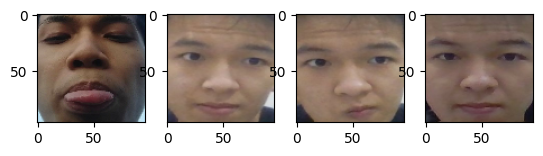

1/1 [==============================] - 0s 47ms/step
(1,2),[[0.94299644]]
1/1 [==============================] - 0s 47ms/step
(1,3),[[0.9934001]]
1/1 [==============================] - 0s 48ms/step
(1,4),[[0.2191608]]
1/1 [==============================] - 0s 45ms/step
(2,3),[[0.16229668]]
1/1 [==============================] - 0s 44ms/step
(2,4),[[0.41357344]]
1/1 [==============================] - 0s 51ms/step
(3,4),[[0.47876614]]


In [52]:
img_a = preprocess_image('mat_hieu3.jpg',(IMG_SIZE, IMG_SIZE))
img_b = preprocess_image('quyen1.jpg',(IMG_SIZE, IMG_SIZE))
img_c = preprocess_image('quyen2.jpg',(IMG_SIZE, IMG_SIZE))
img_d = preprocess_image('quyen3.jpg',(IMG_SIZE, IMG_SIZE))

imgs = [np.expand_dims(preprocess_image(f'trung{i}.jpg',(IMG_SIZE, IMG_SIZE)), axis=0) for i in range(1,16)]

i_a = np.expand_dims(img_a, axis=0)
i_b = np.expand_dims(img_b, axis=0)
i_c = np.expand_dims(img_c, axis=0)
i_d = np.expand_dims(img_d, axis=0)

plt.subplot(1,4,1)
plt.imshow(img_a)
plt.subplot(1,4,2)
plt.imshow(img_b)
plt.subplot(1,4,3)
plt.imshow(img_c)
plt.subplot(1,4,4)
plt.imshow(img_d)
plt.show()


print(f'(1,2),{model.predict([i_a, i_b])}')
print(f'(1,3),{model.predict([i_a, i_c])}')
print(f'(1,4),{model.predict([i_a, i_d])}')
print(f'(2,3),{model.predict([i_b, i_c])}')
print(f'(2,4),{model.predict([i_b, i_d])}')
print(f'(3,4),{model.predict([i_c, i_d])}')




In [ ]:
print(tf.__version__)